# NeDF

## Setting up

In [480]:
# Import all the good stuff
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### GPU vs CPU ?

### Utilitary functions

In [481]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

In [482]:
def fov_to_focal_length(fov: float, width: int) -> float:
    """
    Convert field of view (FOV) to focal length.

    Args:
        fov (float): Field of view in degrees (horizontal).
        width (int): Image width in pixels.

    Returns:
        float: Focal length in pixels.
    """
    fov_tensor = torch.tensor(fov, dtype=torch.float32)
    focal_length = width / (2 * torch.tan(torch.deg2rad(fov_tensor / 2)))
    return focal_length

def pos_angle_to_tform_cam2world(camera_pos: torch.Tensor, camera_angle: torch.Tensor) -> torch.Tensor:
    """
    Create a transformation matrix from camera position and angles.

    Args:
        camera_pos (torch.Tensor): Camera position as (x, y, z).
        camera_angle (torch.Tensor): Camera angles as (pitch, yaw, roll) in degrees.

    Returns:
        torch.Tensor: 4x4 transformation matrix from camera to world.
    """
    pitch, yaw, roll = camera_angle

    # Define rotation matrices
    Rx = torch.tensor([
        [1, 0, 0],
        [0, torch.cos(pitch), -torch.sin(pitch)],
        [0, torch.sin(pitch), torch.cos(pitch)]
    ], dtype=torch.float32)

    Ry = torch.tensor([
        [torch.cos(yaw), 0, torch.sin(yaw)],
        [0, 1, 0],
        [-torch.sin(yaw), 0, torch.cos(yaw)]
    ], dtype=torch.float32)

    Rz = torch.tensor([
        [torch.cos(roll), -torch.sin(roll), 0],
        [torch.sin(roll), torch.cos(roll), 0],
        [0, 0, 1]
    ], dtype=torch.float32)

    # Combine rotation matrices
    rotation_matrix = Rz @ Ry @ Rx

    # Create a 4x4 transformation matrix
    tform_cam2world = torch.eye(4, dtype=torch.float32)
    tform_cam2world[:3, :3] = rotation_matrix
    tform_cam2world[:3, 3] = camera_pos

    return tform_cam2world

def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

### Network architecture

In [483]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeDFModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256, skips=[4], L=10):
        super(NeDFModel, self).__init__()
        self.skips = skips
        self.L = L
        self.input_dim = input_dim
        self.encoded_dim = input_dim + 2 * input_dim * L

        # Input layer
        self.layers = nn.ModuleList([nn.Linear(self.encoded_dim, hidden_dim)])

        # Hidden layers with skip connections
        for i in range(7):
            if i + 1 in skips:
                self.layers.append(nn.Linear(hidden_dim + self.input_dim, hidden_dim))
            else:
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Final layer for distance prediction
        self.output_layer = nn.Linear(hidden_dim, 1)

    def positional_encoding(self, x):
        """Applies NeRF's exact positional encoding to the input.
        Args:
            x (torch.Tensor): Input tensor of shape [B, 3].
        Returns:
            torch.Tensor: Encoded tensor of shape [B, 6L + 3].
        """
        encoded = [x]
        for i in range(self.L):
            frequency = 2.0 ** i * torch.pi
            encoded.append(torch.sin(frequency * x))
            encoded.append(torch.cos(frequency * x))
        return torch.cat(encoded, dim=-1)

    def forward(self, x):
        encoded_x = self.positional_encoding(x)
        input_x = x  # Use raw input points for skip connections
        for i, layer in enumerate(self.layers):
            if i in self.skips:
                encoded_x = torch.cat([input_x, encoded_x], dim=-1)
            encoded_x = F.relu(layer(encoded_x))
        return self.output_layer(encoded_x)
    
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, a=0, nonlinearity='relu')
        nn.init.constant_(layer.bias, 0.1)

In [484]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset loading and processing

In [485]:
DATA_PATH = "./data/robot_orbital_bas"
CAMERAS_PATH = f"{DATA_PATH}/cameras_attributes.npz"
DEPTHS_PATH = f"{DATA_PATH}/depth"

FOV = 30.0
DEPTHMAP_SIZE_RESCALE = 100/1920
SCENE_SCALE = 1/1000

# BASE DATASET STRUCTURE
BASE_CAMERA_LOCATION_ENTRY = "cameras_locations"
BASE_CAMERA_ANGLE_ENTRY = "cameras_angle"

# TARGET DATASET STRUCTURE
RAYS_ENTRY = "rays"
RAY_ORIGINS_ENTRY = "ray_origins"
RAY_DIRECTIONS_ENTRY = "ray_directions"
DEPTH_MAP_ENTRY = "depth_map"
CAMERA_POS_ENTRY = "camera_pos"
CAMERA_ANGLE_ENTRY = "camera_angle"
VALID_INDICES_ENTRY = "valid_indices"
VALID_2D_INDICES_ENTRY = "valid_2D_indices"


In [486]:
# Load camera transforms
cameras = np.load(CAMERAS_PATH)

# Near and far clipping thresholds for depth values
near_thresh = 0.01
far_thresh = 500.0

# Initialize dataset
dataset = {}

print("Loading depth maps, generating rays, and sorting by depth...")
# Load depth maps
for filename in os.listdir(DEPTHS_PATH):
    # Extract the index from the filename
    index = re.search(r'\d+', filename)
    if index:
        index_value = int(index.group())

        # Ignore invalid entries
        angle_norm = np.linalg.norm(cameras[BASE_CAMERA_ANGLE_ENTRY][index_value])
        if angle_norm < 1 - 1e-6:
            print(f"- Skipping index {index_value} due to invalid angle norm: {angle_norm}")
            continue

        # Load the depth map
        depth_map_path = os.path.join(DEPTHS_PATH, filename)
        depth_map = cv2.imread(depth_map_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

        # Resize the depth map
        new_width = int(depth_map.shape[1] * DEPTHMAP_SIZE_RESCALE)
        new_height = int(depth_map.shape[0] * DEPTHMAP_SIZE_RESCALE)
        resized_depth_map = cv2.resize(depth_map, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Scale down the depth (too high for the current model)
        resized_depth_map = resized_depth_map * SCENE_SCALE

        # Compute focal length from FOV
        focal_length = fov_to_focal_length(FOV, new_width)

        # Convert position and angle to transformation matrix
        camera_pos = torch.tensor(cameras[BASE_CAMERA_LOCATION_ENTRY][index_value], dtype=torch.float32)
        camera_angle = torch.tensor(cameras[BASE_CAMERA_ANGLE_ENTRY][index_value], dtype=torch.float32)
        tform_cam2world = pos_angle_to_tform_cam2world(camera_pos, camera_angle)

        # Generate ray bundle
        ray_origins, ray_directions = get_ray_bundle(new_height, new_width, focal_length, tform_cam2world)

        # Store in the dataset
        dataset[index_value] = {
            RAYS_ENTRY: {
                RAY_ORIGINS_ENTRY: ray_origins,
                RAY_DIRECTIONS_ENTRY: ray_directions
            },
            DEPTH_MAP_ENTRY: resized_depth_map,
            CAMERA_POS_ENTRY: camera_pos,
            CAMERA_ANGLE_ENTRY: camera_angle
        }

# Manually remove invalid entries
DATASET_SIZE = len(dataset)
print(f"Successfully generated {DATASET_SIZE} entries!")


Loading depth maps, generating rays, and sorting by depth...
Successfully generated 16 entries!


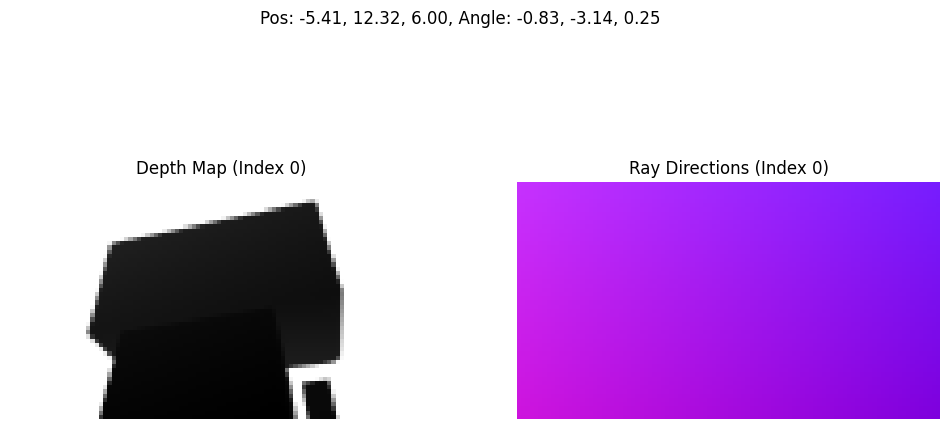

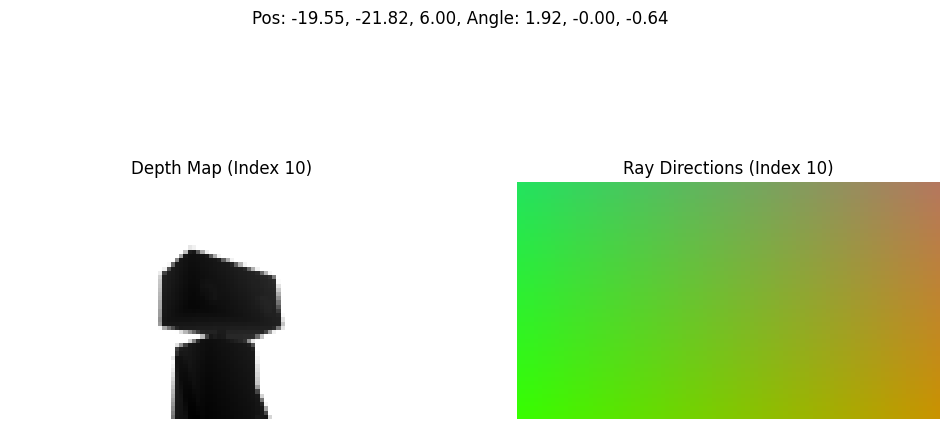

In [487]:
display_every = 10
for idx, data in dataset.items():
    if idx % display_every == 0:
        depth_image = data[DEPTH_MAP_ENTRY]
        ray_origins = data[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
        ray_directions = data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]
        camera_pos = data[CAMERA_POS_ENTRY]
        camera_angle = data[CAMERA_ANGLE_ENTRY]

        # Normalize rays for RGB visualization
        ray_rgb = (ray_directions - ray_directions.min()) / (ray_directions.max() - ray_directions.min())

        # Create a 2x1 plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Depth map
        axes[0].imshow(depth_image, cmap='gray')
        axes[0].set_title(f"Depth Map (Index {idx})")
        axes[0].axis('off')

        # Ray directions as RGB
        axes[1].imshow(ray_rgb.numpy())
        axes[1].set_title(f"Ray Directions (Index {idx})")
        axes[1].axis('off')

        # plt.suptitle(f"Camera Pos: {camera_pos}, Angle: {camera_angle}")
        # Format the camera angle to two decimal places
        formatted_angle = ', '.join([f"{angle:.2f}" for angle in camera_angle])
        formatted_pos = ', '.join([f"{pos:.2f}" for pos in camera_pos])

        # Update the plot title
        plt.suptitle(f"Pos: {formatted_pos}, Angle: {formatted_angle}")
        plt.show()

In [488]:
# Pre-pass function to filter depth and corresponding ray data
def sort_and_filter_depth_map(depth_map, ray_origins, ray_directions):
    # Flatten depth map and corresponding rays
    depth_flat = depth_map.flatten()
    ray_origins_flat = ray_origins.reshape(-1, 3)
    ray_directions_flat = ray_directions.reshape(-1, 3)

    # Validate shapes
    if len(depth_flat) != len(ray_origins_flat) or len(depth_flat) != len(ray_directions_flat):
        raise ValueError(f"Shape mismatch: depth {len(depth_flat)}, rays {len(ray_origins_flat)}")

    # Find maximum depth
    far_thresh = np.max(depth_flat)

    # Filter out max depth values
    valid_mask = depth_flat < far_thresh
    valid_indices = np.where(valid_mask)[0]

    # Calculate and print the percentage of sorted-out values
    removed_percentage = 100 * (len(depth_flat) - len(valid_indices)) / len(depth_flat)
    print(f"Percentage of filtered-out values: {removed_percentage:.2f}%")

    # Extract corresponding valid data
    filtered_depth = depth_flat[valid_indices]
    filtered_ray_origins = ray_origins_flat[valid_indices]
    filtered_ray_directions = ray_directions_flat[valid_indices]

    # Compute 2D indices
    height, width = depth_map.shape
    valid_2d_indices = np.column_stack(np.unravel_index(valid_indices, (height, width)))

    return filtered_depth, filtered_ray_origins, filtered_ray_directions, valid_indices, valid_2d_indices

# Post-process dataset to sort and filter depth maps
def post_process_dataset(dataset):
    print("Post-processing dataset...")

    for index, entry in dataset.items():
        try:
            # Store old values (for reconstruction)
            dataset[index]["OLD" + DEPTH_MAP_ENTRY] = dataset[index][DEPTH_MAP_ENTRY]
            dataset[index]["OLD" + RAYS_ENTRY] = {}
            dataset[index]["OLD" + RAYS_ENTRY][RAY_ORIGINS_ENTRY] =  dataset[index][RAYS_ENTRY][RAY_ORIGINS_ENTRY]
            dataset[index]["OLD" + RAYS_ENTRY][RAY_DIRECTIONS_ENTRY] =  dataset[index][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]
            dataset[index]["OLD" + CAMERA_POS_ENTRY] = dataset[index][CAMERA_POS_ENTRY]

            # Extract depth map and ray data
            depth_map = entry[DEPTH_MAP_ENTRY]
            ray_origins = entry[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
            ray_directions = entry[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]

            # Apply sorting and filtering
            sorted_depth, sorted_ray_origins, sorted_ray_directions, valid_indices, valid_2D_indices = sort_and_filter_depth_map(depth_map, ray_origins, ray_directions)

            # Update dataset entry
            dataset[index][DEPTH_MAP_ENTRY] = sorted_depth / 10.0
            dataset[index][RAYS_ENTRY][RAY_ORIGINS_ENTRY] = sorted_ray_origins / 10.0
            dataset[index][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY] = sorted_ray_directions
            dataset[index][CAMERA_POS_ENTRY] = dataset[index][CAMERA_POS_ENTRY] / 10.0
            dataset[index][VALID_INDICES_ENTRY] = valid_indices
            dataset[index][VALID_2D_INDICES_ENTRY] = valid_2D_indices
        except Exception as e:
            print(f"Error processing index {index}: {e}")

    print("Post-processing complete!")
    return dataset


# Apply post-processing
dataset = post_process_dataset(dataset)

Post-processing dataset...
Percentage of filtered-out values: 53.43%
Percentage of filtered-out values: 83.48%
Percentage of filtered-out values: 83.02%
Percentage of filtered-out values: 82.66%
Percentage of filtered-out values: 81.68%
Percentage of filtered-out values: 75.00%
Percentage of filtered-out values: 63.77%
Percentage of filtered-out values: 52.62%
Percentage of filtered-out values: 62.07%
Percentage of filtered-out values: 72.73%
Percentage of filtered-out values: 76.07%
Percentage of filtered-out values: 78.88%
Percentage of filtered-out values: 81.36%
Percentage of filtered-out values: 82.88%
Percentage of filtered-out values: 83.77%
Percentage of filtered-out values: 83.98%
Post-processing complete!


## Train !

### Sphere tracing
This method renders a depth map using the model's predictions to dynamically adjust step size during ray marching.

In [489]:
def render_depth_sphere_tracing(
    distance_field_model: torch.nn.Module,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    depth_map: torch.Tensor,
    near_thresh: float,
    max_iterations: int = 50,
    grad = True,
) -> torch.Tensor:

    # Create a tensor to track active rays
    active_mask = torch.ones_like(depth_map, dtype=torch.bool)

    # Predicted depth map
    dstTravelled = torch.full_like(depth_map, 0, requires_grad=True)
    steps = torch.zeros_like(active_mask, dtype=torch.float32)
    
    all_query_points = []
    all_predicted_distances = []

    for i in range(max_iterations):
        # Stop if no active rays remain
        if not torch.any(active_mask):
            break
        
        # Compute the query points
        query_points = ray_origins + ray_directions * dstTravelled[..., None]
        query_points.requires_grad_()
        
        # Predict distances using the model
        predicted_distances = distance_field_model(query_points).squeeze(-1)
        
        # Increment the steps for active rays
        steps = torch.where(active_mask, steps + 1, steps)

        # Mask for rays that are within the surface threshold
        hit_mask = (predicted_distances < near_thresh) & active_mask

        # Store active query points and predictions
        all_query_points.append(query_points[~hit_mask])
        all_predicted_distances.append(predicted_distances[~hit_mask])

        # Update active mask to deactivate rays that hit
        active_mask = active_mask & ~hit_mask
        
        # Update the depth map only for rays that have hit
        dstTravelled = torch.where(active_mask, dstTravelled + predicted_distances, dstTravelled)

    # Concatenate query points and distances
    all_query_points = torch.cat(all_query_points, dim=0)
    all_predicted_distances = torch.cat(all_predicted_distances, dim=0)

    return dstTravelled, steps, all_query_points, all_predicted_distances

### Eikonal loss function

In [490]:
def compute_gradients(model, query_points, eps=1e-4, sample_ratio=0.1):
    """
    Computes numerical gradients of SDF using finite differences.

    Args:
    - model: The implicit function.
    - query_points: Tensor of shape [N, 3], query points.
    - eps: Small step for finite differences.
    - sample_ratio: Fraction of points to sample for gradient computation.

    Returns:
    - gradients: Tensor of shape [sampled_N, 3], computed gradients.
    """
    N = query_points.shape[0]
    device = query_points.device

    # Randomly sample query points
    nb_samples = min(int(N * sample_ratio), 5000)
    sampled_indices = torch.randperm(N, device=device)[:nb_samples]
    sampled_points = query_points[sampled_indices]

    # Allocate memory for gradients
    gradients = torch.zeros_like(sampled_points, device=device)

    for i in range(3):  # Compute gradient w.r.t x, y, z
        offset = torch.zeros_like(sampled_points, device=device)
        offset[:, i] = eps

        forward_points = sampled_points + offset
        backward_points = sampled_points - offset

        forward_sdf = model(forward_points).squeeze(-1)
        backward_sdf = model(backward_points).squeeze(-1)

        # Central finite difference
        gradients[:, i] = (forward_sdf - backward_sdf) / (2 * eps)

    return gradients

def compute_eikonal_loss(gradients):
    """
    Computes the Eikonal loss using the computed gradients.

    Args:
    - gradients (torch.Tensor): Tensor of shape [N, 3] containing the gradients of SDF predictions.

    Returns:
    - loss (torch.Tensor): Computed Eikonal loss.
    """
    # ||grad|| should be close to 1, compute the deviation from 1
    loss = torch.mean(torch.abs(torch.norm(gradients, dim=-1) - 1))
    return loss

### Checkpoint saving and loading

In [491]:
# Checkpoint saving function
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    # print(f"Checkpoint saved at {checkpoint_path}")

# Checkpoint loading function
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint from {checkpoint_path}: Epoch {epoch}, Loss: {loss:.4f}")
        return epoch, loss
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        return 0, float('inf')

### Training loop

In [492]:
import os
import torch
import random

# Learning parameters
L = 5
lr = 1e-5

# Model and optimizer
model = NeDFModel(L=L).to(device)
model.apply(initialize_weights)
model.output_layer.bias.data.fill_(1.0)  # Encourage positive values at initialization
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Load previous checkpoint if available
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

No checkpoint found at checkpoints\latest_checkpoint.pth


In [493]:
# Test model with random points
with torch.no_grad():
    scale = 100
    test_points = torch.rand(10, 3, device=device) * scale - torch.tensor([scale/2, scale/2, scale/2], device=device)
    predicted_distances = model(test_points).squeeze(-1).detach().cpu().numpy()
    print(predicted_distances)

[ -7.358034  -24.609423  -16.438799  -18.90588   -10.933479   -3.677443
  -5.5138693 -14.794795  -11.695053   -5.4828463]


C:\Users\Alex\AppData\Local\Temp\ipykernel_10820\2980322250.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_origins = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
C:\Users\Alex\AppData\Local\Temp\ipykernel_10820\2980322250.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)


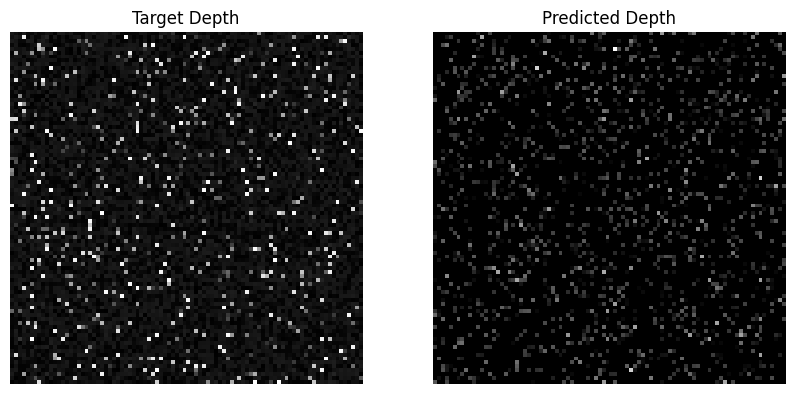


### Step 0 ###
Average steps: 2.32
Total loss: 60.75 (Depth: 1.14, Eikonal: 29.80)
Best loss: 52.41


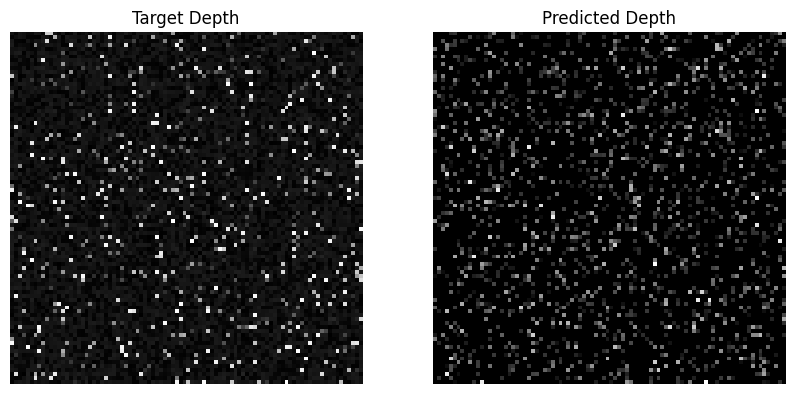


### Step 10 ###
Average steps: 2.32
Total loss: 52.26 (Depth: 1.13, Eikonal: 25.57)
Best loss: 52.41
New best loss!


KeyboardInterrupt: 

In [495]:
# Training parameters
display_every = 10
save_every = 50  # Save every n iterations
batch_size = 1024*8  # Number of rays per batch
eikonal_penalty_weight = 2

num_iters = start_epoch + 10000
near_thresh = 0.1

# Training Loop (Random Ray Sampling Without Loop)
for i in range(start_epoch, num_iters):
    # Sample random dataset indices
    indices = torch.randint(0, len(dataset), (batch_size,))
    # Extract data for all sampled indices
    # data_batch = [list(dataset.values())[idx] for idx in indices.cpu().numpy()]
    data_batch = [list(dataset.values())[0]]

    # Flatten ray and depth arrays for uniform sampling
    target_depth = torch.cat([torch.tensor(data[DEPTH_MAP_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
    ray_origins = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
    ray_directions = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)

    # Sample random pixel coordinates from the flattened array
    rand_coords = torch.randint(0, target_depth.shape[0], (batch_size,))

    # Gather samples
    sampled_depth = target_depth[rand_coords]
    sampled_ray_origins = ray_origins[rand_coords]
    sampled_ray_directions = ray_directions[rand_coords]

    # Ensure there are valid samples left after sampling
    if sampled_ray_origins.shape[0] == 0:
        print("No valid samples found, skipping this batch.")
        continue

    # Perform sphere tracing
    depth_predicted, steps, query_points, query_results = render_depth_sphere_tracing(
        model, sampled_ray_origins, sampled_ray_directions, sampled_depth, near_thresh
    )

    # Correctly reshape to the largest possible square
    valid_size = int(torch.sqrt(torch.tensor(sampled_depth.shape[0], dtype=torch.float32)).floor().item())
    reshaped_predicted = depth_predicted[:valid_size**2].view(valid_size, valid_size).detach().cpu().numpy()
    reshaped_target = sampled_depth[:valid_size**2].view(valid_size, valid_size).detach().cpu().numpy()

    # Display predicted vs target depth
    if i % display_every == 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(reshaped_target, cmap='gray')
        axes[0].set_title("Target Depth")
        axes[0].axis('off')

        axes[1].imshow(reshaped_predicted, cmap='gray')
        axes[1].set_title("Predicted Depth")
        axes[1].axis('off')
        plt.show()

    # Compute Loss
    gradients = compute_gradients(model, query_points)
    eikonal_loss = compute_eikonal_loss(gradients)
    depth_loss = torch.nn.functional.mse_loss(depth_predicted, sampled_depth)
    total_loss = depth_loss + eikonal_loss * eikonal_penalty_weight

    if (total_loss == float('inf') or total_loss == float('nan')):
        print("Loss is infinite or NaN, skipping this batch.")
        continue

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display Progress
    if i % display_every == 0:
        print(f"\n### Step {i} ###")
        print(f"Average steps: {steps.mean().item():.2f}")
        print(f"Total loss: {total_loss.item():.2f} (Depth: {depth_loss.item():.2f}, Eikonal: {eikonal_loss.item():.2f})")
        print(f"Best loss: {best_loss:.2f}")

    # Save checkpoint periodically or if loss improves
    if i % save_every == 0 or total_loss.item() < best_loss:
        if total_loss.item() < best_loss:
            print("New best loss!")
            best_loss = total_loss.item()
        save_checkpoint(model, optimizer, i, total_loss.item(), os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

print("Training complete!")

## Inference

In [ ]:
# Model and optimizer
L = 5
model = NeDFModel(L=L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Load checkpoint
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

### Testing on train dataset

In [ ]:
for i in range(DATASET_SIZE//4):
    # Select one dataset entry
    data_entry = dataset[i]

    # Extract old depth and ray data
    old_target_depth = torch.tensor(data_entry["OLD" + DEPTH_MAP_ENTRY], dtype=torch.float32, device=device)
    old_ray_origins = torch.tensor(data_entry["OLD" + RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32, device=device)
    old_ray_directions = torch.tensor(data_entry["OLD" + RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32, device=device)

    # Perform inference on full data
    width, height = old_ray_origins.shape[1], old_ray_origins.shape[0]
    infinite_depth_map = torch.full((height, width), 10000.0, device=device) # Needed in sphere tracing to let rays go as far as they want
    predicted_depth, _, _, _ = render_depth_sphere_tracing(
        model, old_ray_origins, old_ray_directions, old_target_depth, near_thresh
    )

    # Initialize full depth maps with placeholder
    width, height = old_ray_origins.shape[1], old_ray_origins.shape[0]
    full_predicted_depth = predicted_depth.view(-1).clone()
    full_target_depth = old_target_depth.view(-1).clone()

    # Reshape to 2D
    full_predicted_depth = full_predicted_depth.view(height, width)
    full_target_depth = full_target_depth.view(height, width)

    # Display predicted vs target depth
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(full_target_depth.detach().cpu().numpy(), cmap='gray')
    axes[0].set_title("Target Depth")
    axes[0].axis('off')

    axes[1].imshow(full_predicted_depth.detach().cpu().numpy(), cmap='gray')
    axes[1].set_title("Predicted Depth")
    axes[1].axis('off')
    plt.show()


### Tesing on new camera angles

In [ ]:
for i in range(DATASET_SIZE//4):
    # Interpolate between two camera positions
    data_entry1 = dataset[i]
    data_entry2 = dataset[i + 1]

    cam_pos1 = torch.tensor(data_entry1[CAMERA_POS_ENTRY], dtype=torch.float32, device=device)
    cam_pos2 = torch.tensor(data_entry2[CAMERA_POS_ENTRY], dtype=torch.float32, device=device)

    # Interpolation factor
    alpha = 0.5
    interpolated_cam_pos = cam_pos1 * (1 - alpha) + cam_pos2 * alpha

    # Interpolate camera angles
    cam_dir1 = torch.tensor(data_entry1[CAMERA_ANGLE_ENTRY], dtype=torch.float32, device=device)
    cam_dir2 = torch.tensor(data_entry2[CAMERA_ANGLE_ENTRY], dtype=torch.float32, device=device)
    interpolated_cam_dir = cam_dir1 * (1 - alpha) + cam_dir2 * alpha

    # Generate new rays using the ray generation function
    width, height = 100, 100
    focal_length = fov_to_focal_length(FOV, width)
    tform_cam2world = pos_angle_to_tform_cam2world(interpolated_cam_pos, interpolated_cam_dir)
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, tform_cam2world)
    ray_origins = ray_origins.to(device)
    ray_directions = ray_directions.to(device)

    # Perform inference
    infinite_depth_map = torch.full((height, width), 10000.0, device=device) # Needed in sphere tracing to let rays go as far as they want
    predicted_depth, _, _, _ = render_depth_sphere_tracing(
        model, ray_origins, ray_directions, infinite_depth_map, near_thresh
    )

    # Reshape and visualize
    predicted_depth_2d = predicted_depth.view(height, width)

    # Extract target depth for comparison from first entry
    target_depth_2d = torch.tensor(data_entry1["OLD" + DEPTH_MAP_ENTRY], dtype=torch.float32, device=device)

    # Display predicted vs target depth
    formatted_pos1 = ', '.join([f"{pos:.2f}" for pos in cam_pos1])
    formatted_pos2 = ', '.join([f"{pos:.2f}" for pos in cam_pos2])
    formatted_interpolated_cam_pos = ', '.join([f"{pos:.2f}" for pos in interpolated_cam_pos])
    formatted_dir1 = ', '.join([f"{dir:.2f}" for dir in cam_dir1])
    formatted_dir2 = ', '.join([f"{dir:.2f}" for dir in cam_dir2])
    formatted_interpolated_cam_dir = ', '.join([f"{dir:.2f}" for dir in interpolated_cam_dir])

    print(f"Interpolating between indices {i} and {i + 1}...")
    print(f"pos1: {formatted_pos1}, pos2: {formatted_pos2}, interpolated: {formatted_interpolated_cam_pos}")
    print(f"dir1: {formatted_dir1}, dir2: {formatted_dir2}, interpolated: {formatted_interpolated_cam_dir}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(target_depth_2d.detach().cpu().numpy(), cmap='gray')
    axes[0].set_title("Target Depth")
    axes[0].axis('off')

    axes[1].imshow(predicted_depth_2d.detach().cpu().numpy(), cmap='gray')
    axes[1].set_title("Predicted Depth")
    axes[1].axis('off')
    plt.show()

    
    fig, axes = plt.subplots(1, 3, figsize=(5, 5))
    ray_directions_1 = torch.tensor(data_entry1["OLD" + RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32, device=device)
    axes[0].imshow(ray_directions_1.detach().cpu().numpy())
    axes[0].set_title("Ray Directions 1")
    axes[0].axis('off')

    ray_directions_2 = torch.tensor(data_entry1["OLD" + RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32, device=device)
    axes[1].imshow(ray_directions_2.detach().cpu().numpy())
    axes[1].set_title("Ray Directions 2")
    axes[1].axis('off')
    
    # Display interpolated ray directions as RGB
    axes[2].imshow(ray_directions.detach().cpu().numpy())
    axes[2].set_title("Interpolated Ray Directions")
    axes[2].axis('off')
    plt.show()

